<a href="https://colab.research.google.com/github/Sangchoel/Panoramic_Dental/blob/main/Panoramic_Dental_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyTorch와 TorchVision 설치 (Colab에 이미 설치된 경우가 많음)
!pip install torch torchvision

# OpenCV 설치
!pip install opencv-python-headless

# Matplotlib 설치
!pip install matplotlib

# Albumentations 설치 (선택 사항, 데이터 증강 시 유용)
!pip install albumentations


!pip install --upgrade sympy
# PyTorch 및 TorchVision 재설치
!pip install --upgrade torch torchvision

# sympy 최신 버전 설치
!pip install --upgrade sympy

!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q segmentation_models_pytorch albumentations==1.3.0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.5 MB/s eta 0:00:00


Training UNetEfficientnetB0 start.



Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.9845, Val Loss: 0.9845, IoU: 0.0351
Epoch: 02, Train Loss: 0.9743, Val Loss: 0.9675, IoU: 0.0739
Epoch: 03, Train Loss: 0.9635, Val Loss: 0.9603, IoU: 0.0875
Epoch: 04, Train Loss: 0.9431, Val Loss: 0.9801, IoU: 0.0836
Epoch: 05, Train Loss: 0.9054, Val Loss: 0.9660, IoU: 0.1362
Epoch: 06, Train Loss: 0.8298, Val Loss: 0.9473, IoU: 0.0965
Epoch: 07, Train Loss: 0.7178, Val Loss: 0.8604, IoU: 0.1815
Epoch: 08, Train Loss: 0.5819, Val Loss: 0.8964, IoU: 0.0922
Epoch: 09, Train Loss: 0.4876, Val Loss: 0.9019, IoU: 0.0733
Epoch: 10, Train Loss: 0.4298, Val Loss: 0.7789, IoU: 0.1690
Epoch: 11, Train Loss: 0.3793, Val Loss: 0.6325, IoU: 0.2796
Epoch: 12, Train Loss: 0.3546, Val Loss: 0.8419, IoU: 0.1107
Epoch: 13, Train Loss: 0.3392, Val Loss: 0.7408, IoU: 0.1907
Epoch: 14, Train Loss: 0.3327, Val Loss: 0.6295, IoU: 0.2628
Epoch: 15, Train Loss: 0.3088, Val Loss: 0.6012, IoU: 0.2880
Epoch: 16, Train Loss: 0.2903, Val Loss: 0.6509, IoU: 0.2492
Epoch: 17, Train Loss: 0

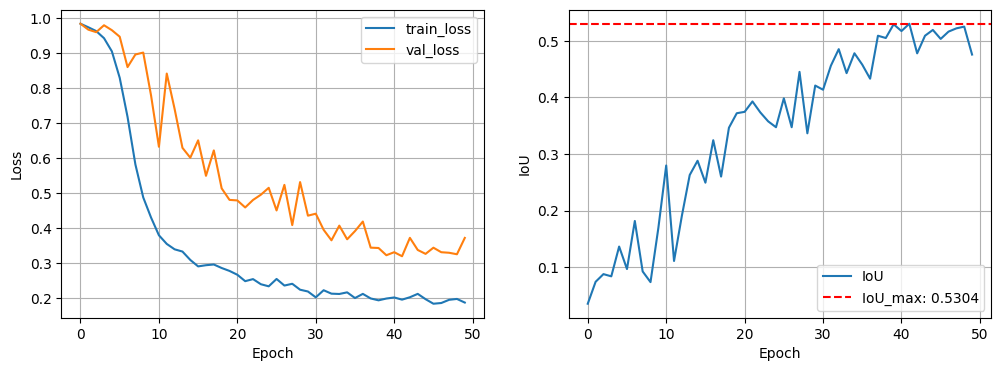

<ipython-input-9-851803223197>:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'{model_name}-best.pth', map_location=device).eval()


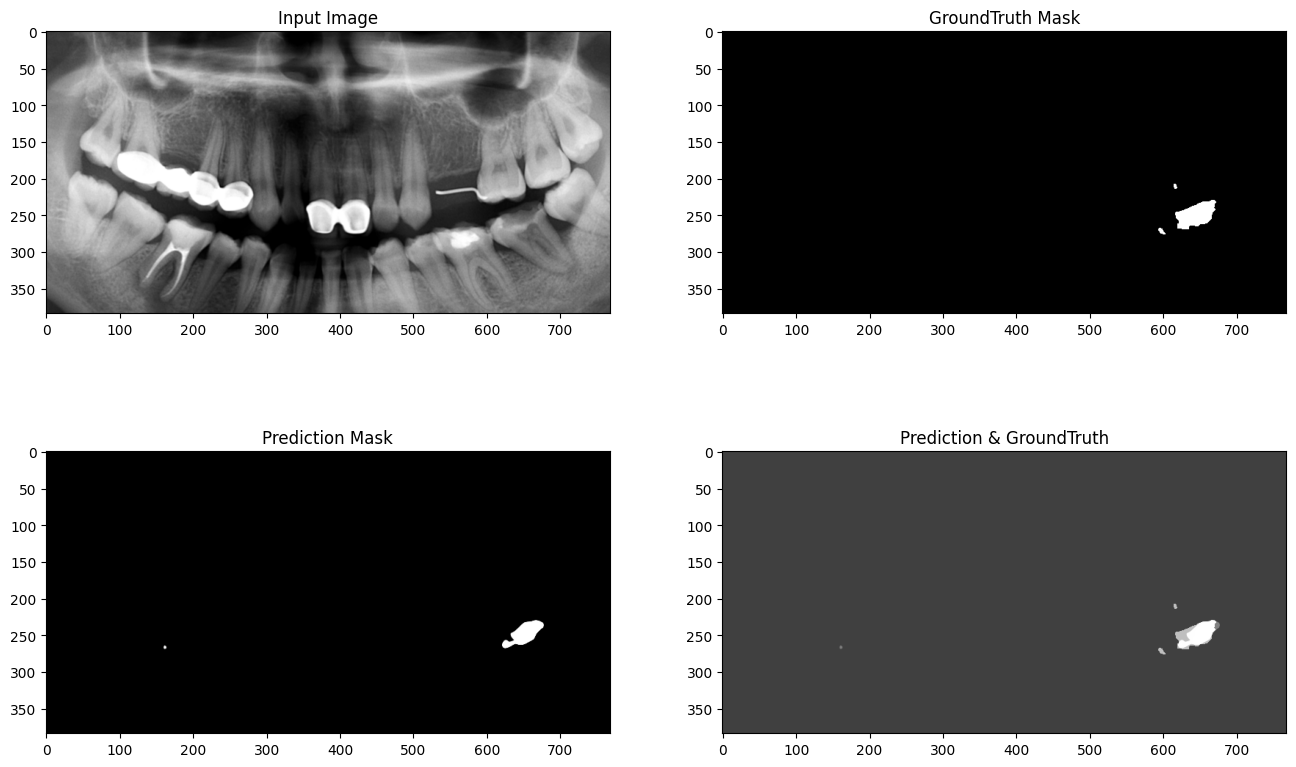

In [9]:
!pip -q install segmentation_models_pytorch

import os
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

warnings.filterwarnings(action='ignore', category=UserWarning)

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CariesDataset 정의
class CariesDataset(Dataset):
    def __init__(self, images_path_list, labels_path_list, augmentation=True, device='cpu', image_size=(384, 768)):
        self.images = images_path_list
        self.labels = labels_path_list
        self.augmentation = augmentation
        self.device = device

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

        if self.augmentation:
            self.same_augmentation = transforms.Compose([
                transforms.RandomRotation(degrees=5),
                transforms.RandomHorizontalFlip(p=0.5)
            ])
            self.different_augmentation = transforms.Compose([
                transforms.RandomAdjustSharpness(2),
                transforms.ColorJitter(brightness=0.5, contrast=0.5)
            ])

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = Image.open(self.labels[idx])

        if self.augmentation:
            seed = np.random.randint(0, 10000)

            torch.random.manual_seed(seed)
            image = self.same_augmentation(image)
            image = self.different_augmentation(image)

            torch.random.manual_seed(seed)
            label = self.same_augmentation(label)

        image = self.transform(image).to(self.device)
        label = self.transform(label).to(self.device)

        # 마스크 이진화
        label = (label != 0).float()

        return image, label

    def __len__(self):
        return len(self.images)

# 본인 구글 드라이브 내 데이터 경로 설정
image_path = '/content/drive/MyDrive/Colab Notebooks/pytorch/Panoramic Dental Dataset/Panoramic Dental Dataset/images_cut'
labels_path = '/content/drive/MyDrive/Colab Notebooks/pytorch/Panoramic Dental Dataset/Panoramic Dental Dataset/labels_cut'

file_names = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

train_image_path = [os.path.join(image_path, fname) for fname in train_files]
train_mask_path  = [os.path.join(labels_path, fname) for fname in train_files]

eval_image_path = [os.path.join(image_path, fname) for fname in val_files]
eval_mask_path  = [os.path.join(labels_path, fname) for fname in val_files]

train_dataset = CariesDataset(
    images_path_list=train_image_path,
    labels_path_list=train_mask_path,
    augmentation=True,
    device=device
)

eval_dataset = CariesDataset(
    images_path_list=eval_image_path,
    labels_path_list=eval_mask_path,
    augmentation=False,
    device=device
)

toPIL = transforms.ToPILImage()

batch_size = 8
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader  = DataLoader(eval_dataset,  shuffle=False, batch_size=1)

# DiceLoss 정의
class DiceLoss(nn.Module):
    def __init__(self, smooth=1, activation=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.activation = activation

    def forward(self, inputs, targets):
        if self.activation:
            inputs = self.activation(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice


# 측정 함수
def metric_calculate(prediction: np.ndarray, target: np.ndarray):
    target = (target.flatten() > 0.5).astype(np.uint8)
    prediction = (prediction.flatten() > 0.5).astype(np.uint8)

    TP = (prediction * target).sum()
    FN = ((1 - prediction) * target).sum()
    TN = ((1 - prediction) * (1 - target)).sum()
    FP = (prediction * (1 - target)).sum()

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-4)
    iou = TP / (TP + FP + FN + 1e-4)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-4)
    pre = TP / (TP + FP + 1e-4)
    spe = TN / (FP + TN + 1e-4)
    sen = TP / (TP + FN + 1e-4)

    return acc, iou, dice, pre, spe, sen

# 모델 로드
model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b0',
    encoder_weights='imagenet',
    in_channels=1,
    classes=1,
).to(device)

model_name = 'UNetEfficientnetB0'
criterion = DiceLoss(activation=F.sigmoid)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epoch = 50

print(f'Training {model_name} start.\n')

IoU_max = 0.
losses_train, losses_val = [], []
metrics = []

for epoch in tqdm(range(num_epoch), desc="Epoch"):
    current_train_loss = 0.
    current_val_loss   = 0.
    current_metric     = np.zeros(6)

    # 1) train
    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        current_train_loss += loss.item() / len(train_dataloader)

    # 2) validation
    model.eval()
    with torch.no_grad():
        for images, labels in eval_dataloader:
            logits = model(images)
            loss   = criterion(logits, labels)
            current_val_loss += loss.item() / len(eval_dataloader)

            # metric
            metric_vals = metric_calculate(
                logits.cpu().numpy(),
                labels.cpu().numpy()
            )
            current_metric += np.array(metric_vals) / len(eval_dataloader)

    losses_train.append(current_train_loss)
    losses_val.append(current_val_loss)
    metrics.append(current_metric.tolist())

    # 베스트 모델 저장 (IoU 기준)
    if IoU_max < metrics[-1][1]:
        torch.save(model, f'{model_name}-best.pth')
        IoU_max = metrics[-1][1]

    print(f"Epoch: {epoch+1:02d}, "
          f"Train Loss: {current_train_loss:.4f}, "
          f"Val Loss: {current_val_loss:.4f}, "
          f"IoU: {metrics[-1][1]:.4f}")

# 로그 저장
log = {
    'train_loss': losses_train,
    'eval_loss':  losses_val,
    'metric':     metrics,
    'best_score': IoU_max
}

with open('log.txt', 'w') as outfile:
    json.dump(log, outfile)

torch.cuda.empty_cache()
print('\n' + '- ' * 30)
print(f'Training {model_name} done. Best IoU: {IoU_max:.4f}.')
print('- ' * 30)

# 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_train, label='train_loss')
plt.plot(losses_val,   label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([m[1] for m in metrics], label='IoU')
plt.axhline(IoU_max, linestyle='--', color='red', label=f'IoU_max: {IoU_max:.4f}')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.savefig('efficientnet-b0.png')
plt.show()

# 추론 (Inference)
model = torch.load(f'{model_name}-best.pth', map_location=device).eval()
image, label = eval_dataset[6]  # 검증 세트 중 임의 인덱스
probabilities = torch.sigmoid(model(image.unsqueeze(0))).squeeze(0)

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(toPIL(label), cmap='gray')
plt.title('GroundTruth Mask')

plt.subplot(2, 2, 3)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Prediction Mask')

plt.subplot(2, 2, 4)
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('Prediction & GroundTruth')
plt.show()
